Требуется защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## 1. Загрузка данных

In [1]:
# pip install -U scikit-learn

In [2]:
# pip install seaborn -U

In [3]:
# Отключим предупреждения Anaconda
import warnings

warnings.simplefilter("ignore")

# Будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns

sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt

# Увеличим дефолтный размер графиков
from pylab import rcParams

rcParams["figure.figsize"] = 8, 5

from math import sqrt

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [4]:
def load_df(name_of_df, separator=",", ind=None):
    """Функция загружает датафрэйм и выводит основные данные по нему.
    Аргументы:
    name_of_df - путь к датафрэйму;
    separator - разделитель;
    ind - столбцы для использования в качестве номеров строк"""

    # Считаем и выведем первые 5 строк таблицы
    df = pd.read_csv(name_of_df, sep=separator, index_col=ind)
    print("Выведем первые 5 строк таблицы:", end="\n\n")
    display(df.head())

    # Вывод основных описательных статистик, общей информации о таблице,
    # пропущенных значений, корреляции признаков, количества дубликатов в данных
    print(
        "\n\n\n\nОтобразим основные описательные статистики по признакам:", end="\n\n"
    )
    display(df.describe())
    print("\n\n\n\nПолучим общую информацию о таблице:", end="\n\n")
    display(df.info())
    print(f"\n\n\n\nПропущенные значения по признакам:", end="\n\n")
    display(pd.DataFrame(df.isnull().sum(), columns=["missing_values"]))
    print(f"\n\n\n\nКорреляция признаков:", end="\n\n")
    display(df.corr())
    sns.pairplot(df)
    return df

Выведем первые 5 строк таблицы:



,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.000,49600.000,1,0
1,0,46.000,38000.000,1,1
2,0,29.000,21000.000,0,0
3,0,21.000,41700.000,2,0
4,1,28.000,26100.000,0,0






Отобразим основные описательные статистики по признакам:



,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000,5000.000,5000.000,5000.000,5000.000
mean,0.499,30.953,39916.360,1.194,0.148
std,0.500,8.441,9900.084,1.091,0.463
min,0.000,18.000,5300.000,0.000,0.000
25%,0.000,24.000,33300.000,0.000,0.000
50%,0.000,30.000,40200.000,1.000,0.000
75%,1.000,37.000,46600.000,2.000,0.000
max,1.000,65.000,79000.000,6.000,5.000






Получим общую информацию о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None





Пропущенные значения по признакам:



,missing_values
Пол,0
Возраст,0
Зарплата,0
Члены семьи,0
Страховые выплаты,0






Корреляция признаков:



,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
Пол,1.000,0.002,0.015,-0.009,0.010
Возраст,0.002,1.000,-0.019,-0.007,0.651
Зарплата,0.015,-0.019,1.000,-0.030,-0.015
Члены семьи,-0.009,-0.007,-0.030,1.000,-0.036
Страховые выплаты,0.010,0.651,-0.015,-0.036,1.000


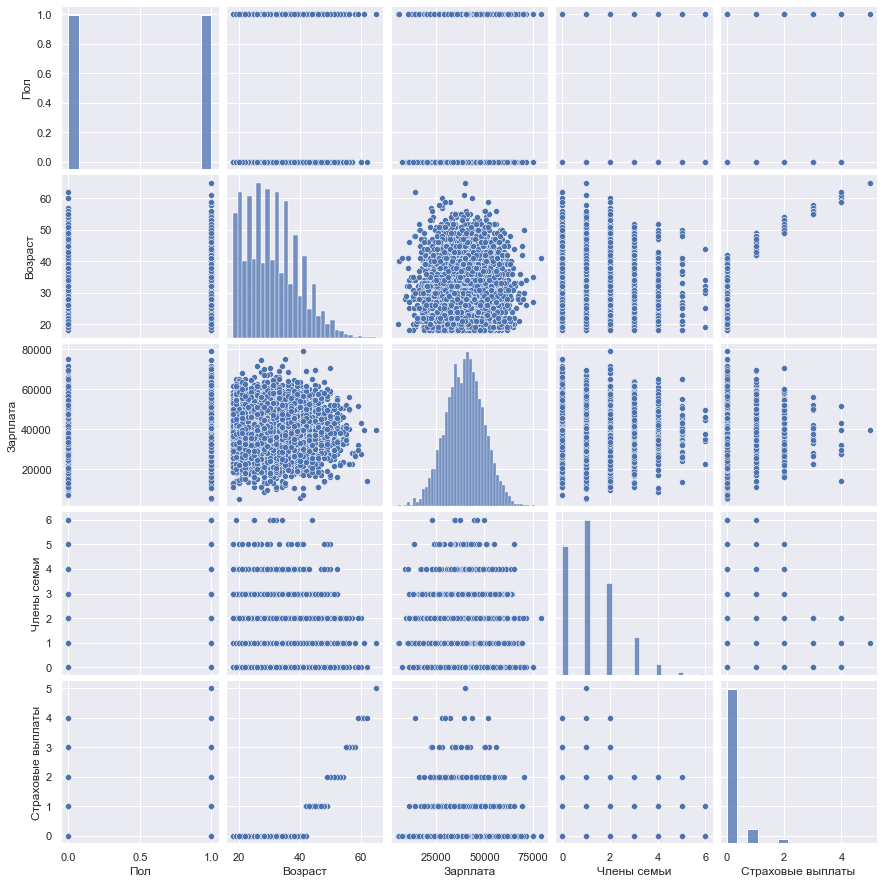

In [5]:
default_df = load_df("https://code.s3.yandex.net/datasets/insurance.csv")

В датафрэйме имеются 5000 объектов (строк) и 5 признаков (столбцов). Все признаки представлены числовым типом данных (int, float).

* Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.
* Целевой признак: количество страховых выплат клиенту за последние 5 лет.

Обратим внимание, что судя по матрице корреляций, у нас нет сильно скоррелированных признаков с целевой переменной. Это пригодится для последующих шагов, в частности, при вычислении определителя матрицы.

## 2. Умножение матриц

Требуется выяснить изменится ли качество линейной регрессии в случае, если признаки умножить на обратимую матрицу.

**Ответ**: при умножении признаков на обратимую матрицу качество линейной регрессии не изменится.

**Обоснование:**

Для начала введём следующие обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Для того, чтобы анонимизировать данные, нужно умножить матрицу с признаками (X) на матрицу P. Чтобы качество линейной регрессии не изменилось, нам важно подобрать такие веса, чтобы:

$$w = \arg\min_w MSE(Xw, y)$$

Выведем формулу, для нахождения весов. В общем виде формула линейной регрессии описывается выражением:

$$ y_i = \alpha + w_1x_{11} + ... + w_nx_{nm} + w_0 $$

где $x_n$ - это вектор из n чисел $x_{n1}, ..., x_{nm}$, а вектор параметров (весов) обозначается как $w$. Также имееся слагаемое $w_0$ - это случайная ошибка (в идеале небольшая), которая появляется в силу факторов, неучтенных моделью. 

Перепишем формулу в матричном виде, принимая во внимание, что во время перемножения матриц, необходимо строки первой матрицы умножать на столбцы другой, а также помнить, что перемножение матриц не коммутативно, т.е. $AB \neq BA$:

$$ y = X * w + w_0 $$

где $y$ - вектор целевой переменной, $w$ - вектор весов, $X$ - матрица признаков, $w_0$ - вектор сдвига.

Преобразуем полученное выражение, добавив значение $w_0$ первым элементом в вектор весов $w$. Также в качестве первого столбца матрицы признаков будет столбец, состоящий из единиц (чтобы в результате перемножения получился свободный член $w_0$). Тогда выражение примет вид:

$$ y = X * w, $$

$$w = w_0, w_1, ... , w_n, $$

$$\begin{equation*}
X = \left(
\begin{array}{ccccc}
1 & x_{11} & x_{12} & \ldots & x_{1n}\\
1 & x_{21} & x_{22} & \ldots & x_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
1 & x_{m1} & x_{m2} & \ldots & x_{mn}
\end{array}
\right)
\end{equation*}$$

Для решения задачи регрессии нам нужно найти веса, т.е. вектор $w$. Есть несколько способов, как это можно сделать, например, посредством математического анализа с помощью дифференциирования:

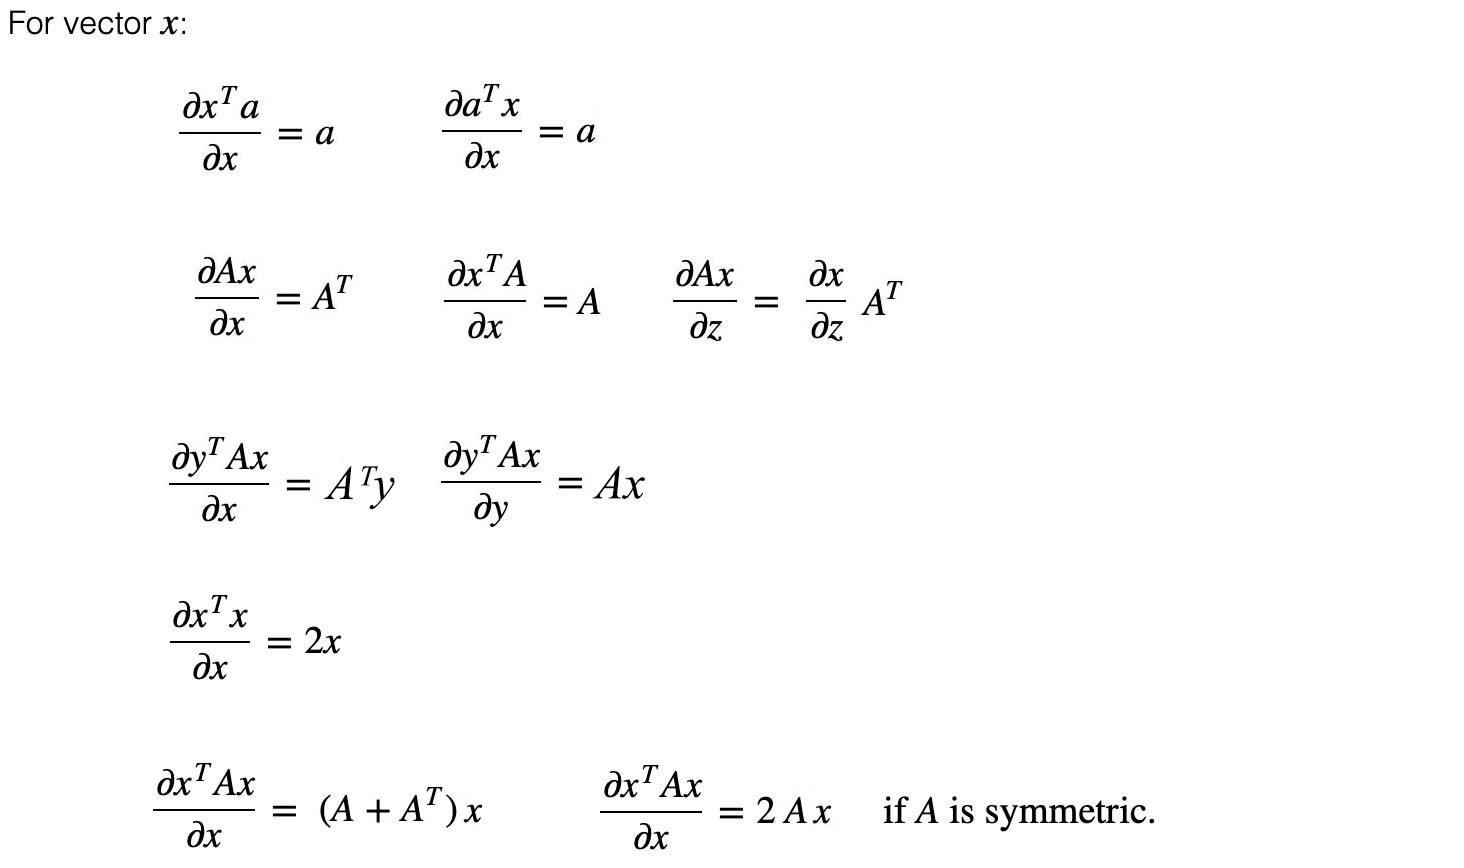

Однако, можно пойти более простым путём. Итак, у нас есть выражение $ y = X * w $, каким образом мы можем выразить $w$? Чтобы в правой части избавиться от $X$, нам нужно обе части домножить на $X^{-1}$. Но тут важно понимать, что мы далеко не всегда можем найти обратную матрицу, и для ее нахождения должны выполняться следующие условия:
* матрица должна быть квадратной;
* определитель матрицы не должен равняться нулю. 

Квадратные матрицы на практике встречаются крайне редко, поэтому у нас должен быть алгоритм, благодаря которому можно преобразовать матрицу к квадратной. Чтобы это сделать, нужно матрицу с признаками (размерностью $n х m$) умножить на транспонированную матрицу (размерностью $m х n$), таким образом, мы получим матрицу размерностью $n х n$.

Чтобы понять, в каком случае определитель равен нулю, воспользуемся определением. По определению, вычисление определителя матрицы сводится к вычислению геометрической функции ориентированного объёма (или ориентированной площади в случае двумерности). Именно ввиду того, что геометрический объем ориентирован, определитель имеет знак.

Признаки между собой не должны быть коллинеарны, а также не должно быть повторяющихся строк. При коллинеарности признаков матрицы X векторы будут почти или полностью равны. Продемонстрируем на графике, и построим два вектора с высокой степенью корреляции:

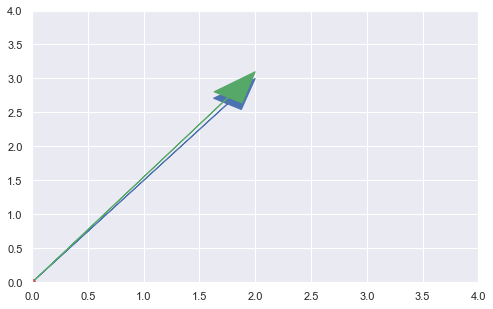

In [6]:
vector1 = np.array([2, 3])
vector2 = np.array([2, 3.1])
plt.axis([0, 4, 0, 4])
plt.arrow(
    0, 0, vector1[0], vector1[1], head_width=0.3, length_includes_head="True", color="b"
)
plt.arrow(
    0, 0, vector2[0], vector2[1], head_width=0.3, length_includes_head="True", color="g"
)
plt.plot(0, 0, "ro")
plt.grid(True)
plt.show()

В данном случае нужно будет вычислить площадь параллелограмма, который построим за счет параллельного переноса vector1 и vector2:

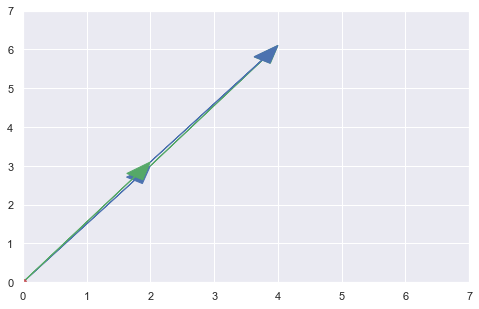

In [7]:
vector1 = np.array([2, 3])
vector2 = np.array([2, 3.1])
vector3 = vector2
vector4 = vector1
plt.axis([0, 7, 0, 7])
plt.arrow(
    0, 0, vector1[0], vector1[1], head_width=0.3, length_includes_head="True", color="b"
)
plt.arrow(
    0, 0, vector2[0], vector2[1], head_width=0.3, length_includes_head="True", color="g"
)
plt.arrow(
    vector1[0],
    vector1[1],
    vector3[0],
    vector3[1],
    head_width=0.3,
    length_includes_head="True",
    color="g",
)
plt.arrow(
    vector2[0],
    vector2[1],
    vector4[0],
    vector4[1],
    head_width=0.3,
    length_includes_head="True",
    color="b",
)
plt.plot(0, 0, "ro")
plt.grid(True)
plt.show()

Очевидно, что площадь такого параллелограмма будет близка к нулю. В случае полной коллинеарности, мы бы получили два вектора, которые лежат друг на друге, и в таком случае ориентированная площадь (определитель) равна нулю, а, следовательно, найти обратную матрицу не представляется возможным.

Учитывая вышесказаное, преобразуем выражение. Для начала оба выражения умножим на $X^T$ слева:

$$ X^T * y = X^T * X * w $$

Теперь мы можем выразить $w$, домножив обе части слева на выражение $(X^T * X)^{-1}$:

$$(X^T * X)^{-1} * X^T * y = (X^T * X)^{-1} * (X^T * X) * w $$

Выражение $(X^T * X)^{-1} * (X^T * X)$ даст нам $E$ или же единичную матрицу - матрицу, на главной диагонали которой 1, а в остальных случаях 0. Таким образом, мы имеем:

$$ w = (X^T * X)^{-1} * X^T * y $$

Мы получили формулу, по которой будет происходить обучение линейной регрессии. Однако, для преобразования данных, следовательно, их защиты, матрица признаков X должна быть умножена на матрицу P. Матрица P должна иметь нормальное распределение, это важно, чтобы случайные ошибки были распределены нормально. Почему же умножение матрицы X на нормально распределенную матрицу P не изменит качества линейной регрессии? Потому как в любом случае будут подобраны веса $w$, несмотря на то, что значения вектора $w$ будут несколько другие, чем были бы, если бы мы не умножали матрицу признаков X на P. Параметры линейной регрессии в исходной задаче и в преобразованной будут связаны линейно.

Проверим нашу теорию на практике и обучим модель линейной регрессии, после чего рассчитаем значение метрики $R^2$. Для начала сгенерируем матрицу $P$.

In [8]:
state = np.random.RandomState(12345)
P = state.normal(0, 1, (4, 4))

Матрица P: 
[[-0.20470766  0.47894334 -0.51943872 -0.5557303 ]
 [ 1.96578057  1.39340583  0.09290788  0.28174615]
 [ 0.76902257  1.24643474  1.00718936 -1.29622111]
 [ 0.27499163  0.22891288  1.35291684  0.88642934]]


Text(0.5, 1.0, 'График распределения признаков матрицы P')

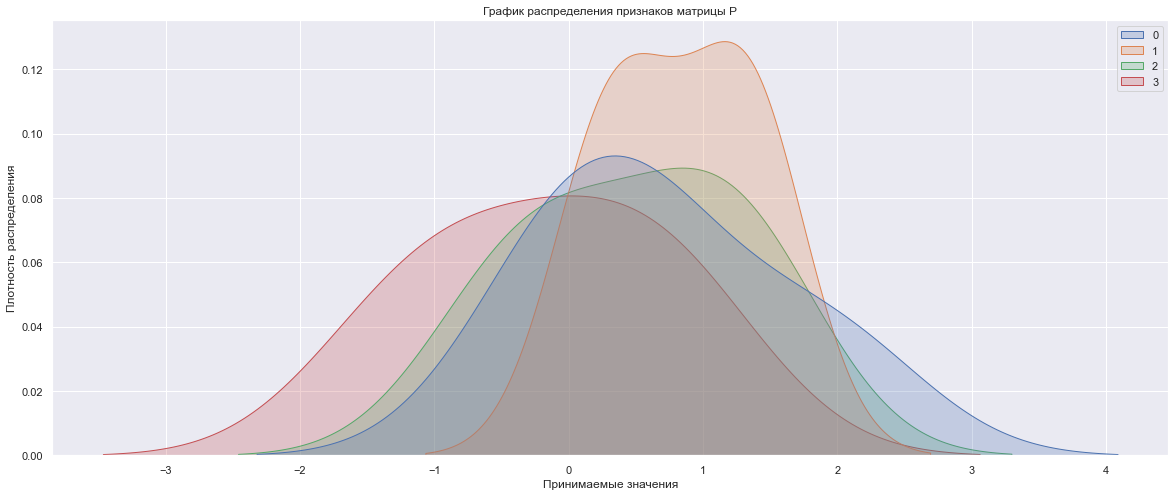

In [9]:
# Посмотрим на получившиеся значения и распределения признаков матрицы P

print("Матрица P: ", P, sep="\n")

f, ax = plt.subplots(figsize=(20, 8))
sns.kdeplot(data=P, shade=1, ax=ax)
ax.set(xlabel="Принимаемые значения", ylabel="Плотность распределения")
ax.set_title("График распределения признаков матрицы P")

Разделим датасэт на обучающие признаки (предикторы) и целевую переменную.

In [10]:
X = default_df.drop("Страховые выплаты", axis=1)

In [11]:
y = default_df["Страховые выплаты"]

In [12]:
lin_regr_model = LinearRegression(normalize=True, n_jobs=-1)

In [13]:
lin_regr_model.fit(X, y)

LinearRegression(n_jobs=-1, normalize=True)

In [14]:
lin_regr_model.score(X, y)

0.4249455028666801

Исходя из определения метрики $R^2$, мы видим, что наша модель работает лучше случайной. Теперь посмотрим на значение метрики $R^2$ в случае с преобразованной матрицей X.

In [15]:
X_transformed = np.dot(X, P)

In [16]:
lin_regr_model_transformed = LinearRegression(normalize=True, n_jobs=-1)
lin_regr_model_transformed.fit(X_transformed, y)
lin_regr_model_transformed.score(X_transformed, y)

0.4249455028666811

Значение метрики практически не изменилось, исходя из чего можно сделать вывод, что проделанные с матрицей преобразования никак не повлияли на качество линейной регрессии.

## Вывод

Мы доказали, что при умножении матрицы признаков на обратимую матрицу, качество метрики $R^2$ не изменится.

## 3. Алгоритм преобразования

**Алгоритм**:

Для того, чтобы выполнить преобразование, мы можем создать матрицу размерностью $n x n$ (число строк и столбцов сгенерированной матрицы должно быть равно числу столбцов матрицы признаков), которая распределена нормально (ранее объяснялось, для чего это необходимо), найти матрицу обратную к ней, после чего умножить матрицу с признаками на полученную матрицу. 

**Обоснование**:

Качество линейной регрессии в таком случае должно остаться неизменным, т.к. будет линейная взаимосвязь между исходными параметрами линейной регрессии и преобразованными. То есть, на выходе мы получим матрицу размером $m x n$. Качество линейной регрессии не изменится в том случае, если подберутся веса, найдутся решения, а для этого необходимо, чтобы сгенерированная матрица имела нормальное распределение, была обратима, а также, чтобы между признаками не было линейной зависимости. Несмотря на то, что модель линейной регрессии подберет другие веса, нежели были бы при отсутсвии преобразования, решение в любом случае найдется, что является необходимым и достаточным условием.

## 4. Проверка алгоритма

Проверим предложенный алгоритм на практике и убедимся, что это не окажет влияние на качество метрики $R^2$.

In [17]:
state = np.random.RandomState(12345)
transform_matrix = state.normal(size=(X.shape[1], X.shape[1]))
rev_matrix = np.linalg.inv(transform_matrix)

Матрица rev_matrix: 
[[-1.31136747  0.3921804   0.18868055 -0.67088287]
 [ 1.75872714  0.14106138 -0.17773045  0.79787127]
 [-0.41702659 -0.22854768  0.3550602   0.33039819]
 [ 0.58912996  0.19073027 -0.5545481   0.6259302 ]]


Text(0.5, 1.0, 'График распределения признаков матрицы rev_matrix')

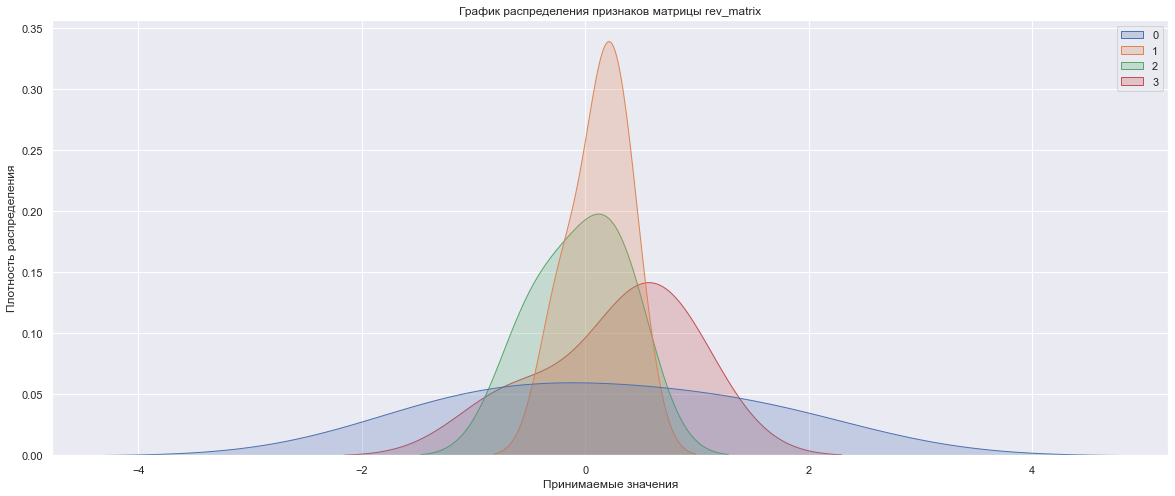

In [18]:
# Посмотрим на получившиеся значения и распределения признаков матрицы rev_matrix

print("Матрица rev_matrix: ", rev_matrix, sep="\n")

f, ax = plt.subplots(figsize=(20, 8))
sns.kdeplot(data=rev_matrix, shade=1, ax=ax)
ax.set(xlabel="Принимаемые значения", ylabel="Плотность распределения")
ax.set_title("График распределения признаков матрицы rev_matrix")

Теперь выполним преобразование исходной матрицы с признаками X.

In [19]:
def encryption_matrix(matrix):
    state = np.random.RandomState(12345)
    new_matrix_normal = state.normal(size=(matrix.shape[1], matrix.shape[1]))
    rev_matrix = np.linalg.inv(new_matrix_normal)
    encrypted = np.dot(matrix, rev_matrix)
    return encrypted

In [20]:
X_transformed_algorithm = encryption_matrix(X)

In [21]:
lin_regr_model_transformed = LinearRegression(normalize=True, n_jobs=-1)
lin_regr_model_transformed.fit(X_transformed_algorithm, y)
lin_regr_model_transformed.score(X_transformed_algorithm, y)

0.4249455028666872

Мы видим, что качество линейной регрессии почти никак не изменилось, несмотря на то, что мы выполнили матричные преобразования и изменили распределение изначальной матрицы.

# Общий вывод

В рамках данного проекта мы реализовали алгоритм преобразования исходных признаков, а также выяснили, что данные преобразования никоим образом не отразились на качестве линейной регрессии (её метрики $R^2$). Это связано с тем, что в случае отсутствия коллинеарности между признаками, обратимости сгенерированной матрицы (а она обратима, если она квадратична и нет линейной зависимости между строками и столбцами), веса линейной регрессии $w$ будут подобраны, следовательно, это не окажет отрицательного влияния на значении метрики.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные загружены
- [ ]  Выполнен шаг 2: получен ответ на вопрос об умножении матриц
    - [ ]  Указан правильный вариант ответа
    - [ ]  Вариант обоснован
- [ ]  Выполнен шаг 3: предложен алгоритм преобразования
    - [ ]  Алгоритм описан
    - [ ]  Алгоритм обоснован
- [ ]  Выполнен шаг 4: алгоритм проверен
    - [ ]  Алгоритм реализован
    - [ ]  Проведено сравнение качества моделей до и после преобразования